In [1]:
import tensorflow as tf
import numpy as np
import random
from collections import deque

INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch
GAMMA = 0.9 # discount factor for target Q

class agent():
    def __init__(self, env):
        # self.state_dim = env.observation_space.shape[0]
        self.state_dim = 4
        # self.action_dim = env.action_space.n
        self.action_dim = 4
        self.create_Q_network()  # otherwise: AttributeError: agent instance has no attribute 'Q_value'

        self.create_training_method()
        self.teacher_create()

        # Otherwise: ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. 
        # Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`
        # Init session
        self.session = tf.InteractiveSession()
        self.session.run(tf.global_variables_initializer())

        # Otherwise: AttributeError: agent instance has no attribute 'epsilon'
        self.epsilon = INITIAL_EPSILON

        # init experience replay
        self.replay_buffer = deque()

        # init some parameters
        self.time_step = 0

        # The position of this code should not be there, but before "self.session"
        # self.create_training_method()
    def create_Q_network(self):
        # input: state, 
        # output: value of action

        # network weights
        W1 = self.weight_variable([self.state_dim,20])
        b1 = self.bias_variable([20])
        W2 = self.weight_variable([20,self.action_dim])
        b2 = self.bias_variable([self.action_dim])
        # input layer
        self.state_input = tf.placeholder("float",[None,self.state_dim])
        # hidden layers
        h_layer = tf.nn.relu(tf.matmul(self.state_input,W1) + b1)
        # Q Value layer
        self.Q_value = tf.matmul(h_layer,W2) + b2
    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)

    def egreedy_action(self,state):
        Q_value = self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0]
        # the value of  "INITIAL_EPSILON" and "FINAL_EPSILON" will not change
        # but the value of "self.epsilon" will decrease
        self.epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/10000

        if random.random() <= self.epsilon:
            return random.randint(0,self.action_dim - 1)
        else:
            return np.argmax(Q_value)
    def sess_close(self):
        self.session.close()
    
    def perceive(self,state,action,reward,next_state,done):
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
        # print self.replay_buffer
        if len(self.replay_buffer) > REPLAY_SIZE-3000:
            self.replay_buffer.popleft()
        # train very frequently
        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()
    def teacher_create(self):

        A=deque()
        target_x=0
        target_y=0
        move_x=20
        move_y=20
        for i in range(20):
            state=np.array([target_x, target_y, move_x, move_y])
            move_x=move_x-1
            next_state=np.array([target_x, target_y, move_x, move_y])
            A.append(( state, np.array([ 0.,  0.,  0.,  1.]), -1, next_state, 0 ))

        for i in range(19):
            state=np.array([target_x, target_y, move_x, move_y])
            move_y=move_y-1
            next_state=np.array([target_x, target_y, move_x, move_y])
            A.append(( state, np.array([ 0.,  1.,  0.,  0.]), -1, next_state, 0 ))

        if 1==1:
            state=np.array([target_x, target_y, move_x, move_y])
            move_y=move_y-1
            next_state=np.array([target_x, target_y, move_x, move_y])
            A.append(( state, np.array([ 0.,  1.,  0.,  0.]), 20, next_state, 1 ))

        while len(A)<3000:
            A+=A
        while len(A)>3000:
            A.popleft()

        self.teacher_deque=A
    def train_Q_network(self):
        # Step 1: obtain random minibatch from replay memory
        self.time_step += 1
        tmp_deque=deque()
        tmp_deque+=self.teacher_deque
        tmp_deque+=self.replay_buffer

        minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]

        Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})

        # Step 2: calculate y
        y_batch = []
        for i in range(0,BATCH_SIZE):
            done = minibatch[i][4]
            if done:
                y_batch.append(reward_batch[i]) # always be 1
            else :
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={self.y_input: y_batch, self.action_input: action_batch, self.state_input: state_batch})

    def create_training_method(self):
        self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
        self.y_input = tf.placeholder("float",[None])
        # Notice: Q_value is decided by "self.state_input:"
        Q_action = tf.reduce_sum(tf.multiply(self.Q_value,self.action_input),reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)
    def action(self,state):
        return np.argmax(self.Q_value.eval(feed_dict = {self.state_input:[state]})[0])

In [2]:
TRAIN_EPISODE = 100
EPISODE = 100 # Episode limitation

import class_xy_move

# step 1: connect the gym
# import gym
env = class_xy_move.xy_move()

my_agent = agent(env)

reward_save = []

for i_test_episode in range(TRAIN_EPISODE):
    k=0
    for episode in range(EPISODE):
        state = env.reset()
        
        # should avoid infinite loop here:
        for __ in range(300):
            # env.render() # maybe work for the display of car-pole
            # action = env.action_space.sample()
            action = my_agent.egreedy_action(state)
            next_state,reward,done,_ = env.step(action)
            my_agent.perceive(state,action,reward,next_state,done)
            state = next_state
            # print state,action,reward,next_state,done
            if done:
                # print "done! with run: ", k
                # k=k+1
                break

    # my_agent.train_Q_network()

    # wether the network be better, test it
    total_reward = 0
    for i in range(1):
        state = env.reset()
        
        # should avoid infinite loop here:
        for __ in range(300):
            # env.render()
            action = my_agent.action(state) # direct action for test
            state,reward,done,_ = env.step(action)
            total_reward += reward
            if done:
                print( "done! with test: ", i)
                break
    print( i_test_episode, "--> total_reward: ", total_reward)
    reward_save.append(total_reward)

0 --> total_reward:  -300
1 --> total_reward:  -300
done! with test:  0
2 --> total_reward:  -42
3 --> total_reward:  -300
done! with test:  0
4 --> total_reward:  -40
done! with test:  0
5 --> total_reward:  -40
done! with test:  0
6 --> total_reward:  -40
done! with test:  0
7 --> total_reward:  -40
done! with test:  0
8 --> total_reward:  -40
9 --> total_reward:  -300
10 --> total_reward:  -300
11 --> total_reward:  -300
done! with test:  0
12 --> total_reward:  -40
done! with test:  0
13 --> total_reward:  -40
done! with test:  0
14 --> total_reward:  -40
done! with test:  0
15 --> total_reward:  -40
16 --> total_reward:  -300
17 --> total_reward:  -300
18 --> total_reward:  -300
19 --> total_reward:  -300
20 --> total_reward:  -300
done! with test:  0
21 --> total_reward:  -40
done! with test:  0
22 --> total_reward:  -40
23 --> total_reward:  -300
24 --> total_reward:  -300
done! with test:  0
25 --> total_reward:  -40
done! with test:  0
26 --> total_reward:  -40
done! with test

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

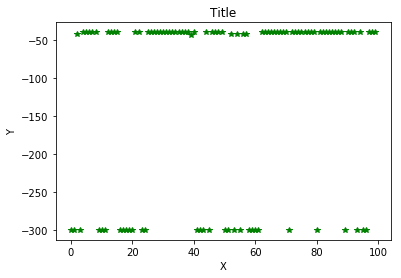

In [8]:
xypoints = reward_save

plt.plot(np.array(xypoints).reshape(-1), 'g*')#, label='--'
plt.title('Title')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(loc='upper right')
plt.show()



In [ ]:
# 眼睛里要容得下沙子